In [1]:
# ============================================================
# WORKSHOP 4 - SIMULATION 1: DATA-DRIVEN MACHINE LEARNING
# HCT Survival Equity System Analysis
# ============================================================
# Build a Gradient Boosting model to predict event-free survival
# ============================================================

In [2]:
# ------------------------------
# CELL 1: Setup the directory
# ------------------------------
# For Google Colab - skip if running locally
# ------------------------------
import os

%cd /content

# Clone repo if not already there
if not os.path.exists('HCT_Survival_Equity_System_Analysis'):
    !git clone https://github.com/SaiLord28/HCT_Survival_Equity_System_Analysis.git

%cd HCT_Survival_Equity_System_Analysis/4_workshop

print(f"Working directory: {os.getcwd()}")
print("\nFiles in data/:")
!ls -la data/

/content
Cloning into 'HCT_Survival_Equity_System_Analysis'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 215 (delta 5), reused 12 (delta 3), pack-reused 192 (from 1)
Receiving objects: 100% (215/215), 26.13 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/HCT_Survival_Equity_System_Analysis/4_workshop
Working directory: /content/HCT_Survival_Equity_System_Analysis/4_workshop

Files in data/:
total 9656
drwxr-xr-x 2 root root    4096 Nov 28 22:18 .
drwxr-xr-x 3 root root    4096 Nov 28 22:18 ..
-rw-r--r-- 1 root root    6006 Nov 28 22:18 data_dictionary.csv
-rw-r--r-- 1 root root 9868662 Nov 28 22:18 train.csv


In [3]:
# ------------------------------
# CELL 2: Install dependencies
# ------------------------------
!pip install pandas numpy matplotlib seaborn scikit-learn -q

In [4]:
# ------------------------------
# CELL 3: Imports
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Parameters
RANDOM_STATE = 42
N_ITERATIONS = 5           # How many times to train the model
INSTABILITY_THRESHOLD = 0.15  # Max acceptable variation
ACCURACY_TARGET = 0.70     # Minimum accuracy we want

print("Libraries imported successfully")

Libraries imported successfully


In [5]:
# ------------------------------
# CELL 4: Load data
# ------------------------------
df = pd.read_csv('data/train.csv')

print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nTarget column 'efs': {df['efs'].unique()}")
print(f"\nClass distribution:\n{df['efs'].value_counts()}")

Dataset shape: 28800 rows, 60 columns

Unique values in 'efs': [0. 1.]

Value counts:
efs
1.0    15532
0.0    13268
Name: count, dtype: int64


In [6]:
# ------------------------------
# CELL 5: Preprocessing
# ------------------------------
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_processed = df.copy()

# Convert target to binary (1 = Event, 0 = Censoring)
if df_processed['efs'].dtype == 'object':
    df_processed['efs'] = df_processed['efs'].map({'Event': 1, 'Censoring': 0})

# Columns to exclude from features
exclude_cols = ['ID', 'efs', 'efs_time']

# Split columns by type
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in exclude_cols]

# Fill missing values
for col in numeric_cols:
    if df_processed[col].isna().any():
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

for col in categorical_cols:
    if df_processed[col].isna().any():
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

# Encode categorical columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = df_processed[col].astype(str)
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le

# Scale numeric columns
scaler = StandardScaler()
df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

print(f"Preprocessing done: {df_processed.shape}")
print(f"Class 0: {(df_processed['efs']==0).sum()}, Class 1: {(df_processed['efs']==1).sum()}")

/tmp/ipython-input-2568630575.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].median(), inplace=True)
/tmp/ipython-input-2568630575.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Preprocessing done: (28800, 60)
Class 0: 13268, Class 1: 15532


In [7]:
# ------------------------------
# CELL 6: Prepare features
# ------------------------------
all_features = [c for c in df_processed.columns if c not in exclude_cols]

X = df_processed[all_features].copy()
y = df_processed['efs'].copy()

# Remove rows with missing target
valid_mask = y.notna()
X = X[valid_mask]
y = y[valid_mask]

print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")

Final dataset: 28800 samples, 57 features


In [8]:
# ------------------------------
# CELL 7: Train GBM models
# ------------------------------
# Train multiple times to check stability
# ------------------------------
print("=" * 60)
print("SIMULATION 1: DATA-DRIVEN MACHINE LEARNING")
print("=" * 60)

results = {
    'accuracy': [],
    'auc': [],
    'models': [],
    'seeds': []
}

print(f"\nRunning {N_ITERATIONS} iterations...\n")

for i in range(N_ITERATIONS):
    seed = RANDOM_STATE + i * 10
    results['seeds'].append(seed)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    # Train model
    model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=seed
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results['accuracy'].append(acc)
    results['auc'].append(auc)
    results['models'].append(model)

    print(f"Iteration {i+1}: Accuracy={acc:.4f}, AUC={auc:.4f}")

SIMULATION 1: DATA-DRIVEN MACHINE LEARNING

Running 5 iterations...

Iteration 1: Accuracy=0.6892, AUC=0.7554
Iteration 2: Accuracy=0.6816, AUC=0.7374
Iteration 3: Accuracy=0.6660, AUC=0.7262
Iteration 4: Accuracy=0.6823, AUC=0.7460
Iteration 5: Accuracy=0.6727, AUC=0.7302


In [9]:
# ------------------------------
# CELL 8: Variability analysis
# ------------------------------
# Check if model results are stable across runs
# ------------------------------
print("\n--- Variability Analysis ---")

accuracy_array = np.array(results['accuracy'])
auc_array = np.array(results['auc'])

acc_mean = np.mean(accuracy_array)
acc_std = np.std(accuracy_array)
auc_mean = np.mean(auc_array)
auc_std = np.std(auc_array)
acc_cv = acc_std / acc_mean  # Coefficient of variation

print(f"Accuracy: {acc_mean:.4f} +/- {acc_std:.4f}")
print(f"AUC: {auc_mean:.4f} +/- {auc_std:.4f}")
print(f"CV: {acc_cv:.4f} (threshold: {INSTABILITY_THRESHOLD})")

if acc_cv <= INSTABILITY_THRESHOLD:
    print(f"\n[OK] Model is stable")
else:
    print(f"\n[WARNING] Model is unstable")

if acc_mean >= ACCURACY_TARGET:
    print(f"[OK] Accuracy meets target")
else:
    print(f"[WARNING] Accuracy below target")


--- Variability Analysis ---
Accuracy: 0.6784 +/- 0.0081
AUC: 0.7391 +/- 0.0106
CV: 0.0120 (threshold: 0.15)

[OK] Model is stable (CV <= 0.15)
[WARNING] Accuracy below target (< 0.7)


In [10]:
# ------------------------------
# CELL 9: Chaos sensitivity analysis
# ------------------------------
# Test how model reacts to small input perturbations
# ------------------------------
print("\n--- Chaos Sensitivity (Butterfly Effect) ---")

perturbation_levels = [0.01, 0.05, 0.10, 0.15]

# Train baseline model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

base_model = GradientBoostingClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE
)
base_model.fit(X_train, y_train)

base_pred = base_model.predict(X_test)
base_acc = accuracy_score(y_test, base_pred)
base_auc = roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])

chaos_results = []

# Add noise and measure impact
for level in perturbation_levels:
    noise = np.random.normal(0, level, X_test.shape)
    X_test_noisy = X_test + noise

    noisy_pred = base_model.predict(X_test_noisy)
    noisy_proba = base_model.predict_proba(X_test_noisy)[:, 1]

    noisy_acc = accuracy_score(y_test, noisy_pred)
    noisy_auc = roc_auc_score(y_test, noisy_proba)
    pred_change = np.mean(base_pred != noisy_pred)

    chaos_results.append({
        'perturbation': level,
        'accuracy': noisy_acc,
        'auc': noisy_auc,
        'accuracy_drop': base_acc - noisy_acc,
        'prediction_change': pred_change
    })

    print(f"Noise {level*100:.0f}%: Acc={noisy_acc:.4f}, Changed={pred_change*100:.1f}%")

chaos_df = pd.DataFrame(chaos_results)


--- Chaos Sensitivity Analysis (Butterfly Effect) ---
Perturbation 1%: Acc=0.6877 (delta=+0.0016), Changed predictions=0.5%
Perturbation 5%: Acc=0.6891 (delta=+0.0002), Changed predictions=1.2%
Perturbation 10%: Acc=0.6847 (delta=+0.0045), Changed predictions=3.1%
Perturbation 15%: Acc=0.6830 (delta=+0.0063), Changed predictions=4.9%


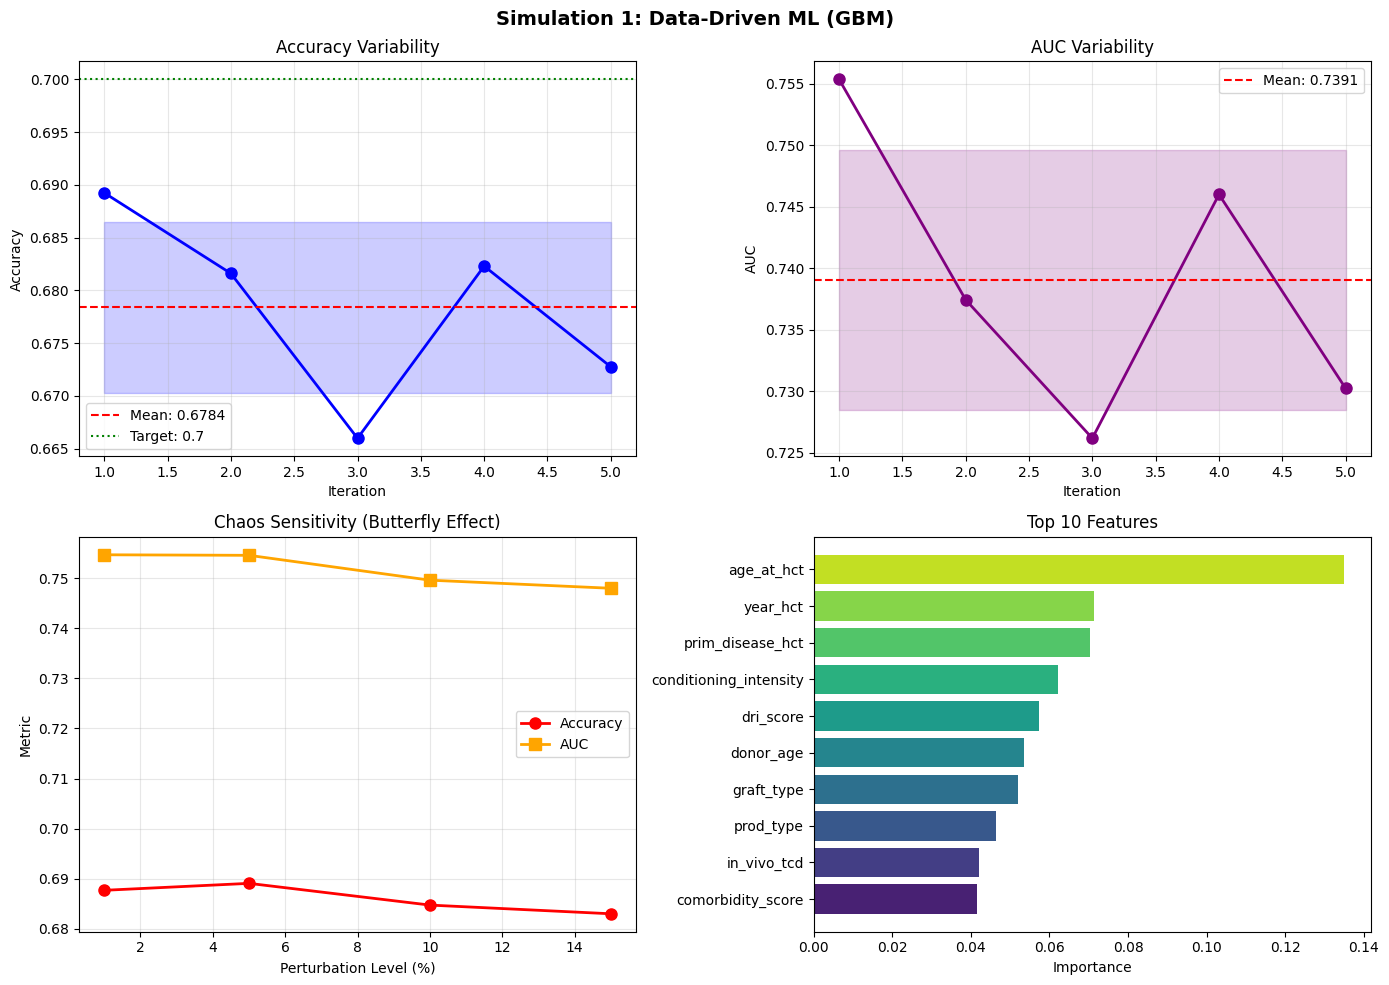


Figure saved: simulation1_results.png


In [11]:
# ------------------------------
# CELL 10: Visualizations
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy across iterations
ax1 = axes[0, 0]
ax1.plot(range(1, N_ITERATIONS+1), results['accuracy'], 'o-', color='blue', markersize=8, linewidth=2)
ax1.axhline(y=acc_mean, color='red', linestyle='--', label=f'Mean: {acc_mean:.4f}')
ax1.axhline(y=ACCURACY_TARGET, color='green', linestyle=':', label=f'Target: {ACCURACY_TARGET}')
ax1.fill_between(range(1, N_ITERATIONS+1), acc_mean - acc_std, acc_mean + acc_std, alpha=0.2, color='blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Variability')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: AUC across iterations
ax2 = axes[0, 1]
ax2.plot(range(1, N_ITERATIONS+1), results['auc'], 'o-', color='purple', markersize=8, linewidth=2)
ax2.axhline(y=auc_mean, color='red', linestyle='--', label=f'Mean: {auc_mean:.4f}')
ax2.fill_between(range(1, N_ITERATIONS+1), auc_mean - auc_std, auc_mean + auc_std, alpha=0.2, color='purple')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('AUC')
ax2.set_title('AUC Variability')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Chaos sensitivity
ax3 = axes[1, 0]
ax3.plot(chaos_df['perturbation'] * 100, chaos_df['accuracy'], 'o-', color='red', markersize=8, linewidth=2, label='Accuracy')
ax3.plot(chaos_df['perturbation'] * 100, chaos_df['auc'], 's-', color='orange', markersize=8, linewidth=2, label='AUC')
ax3.set_xlabel('Perturbation Level (%)')
ax3.set_ylabel('Metric')
ax3.set_title('Chaos Sensitivity')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Feature importance (top 10)
ax4 = axes[1, 1]
best_idx = np.argmax(results['auc'])
best_model = results['models'][best_idx]
importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importance
}).sort_values('importance', ascending=True).tail(10)

colors = sns.color_palette("viridis", len(importance_df))
ax4.barh(importance_df['feature'], importance_df['importance'], color=colors)
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Features')

plt.suptitle('Simulation 1: Data-Driven ML (GBM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('simulation1_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: simulation1_results.png")

In [12]:
# ------------------------------
# CELL 11: Summary
# ------------------------------
print("\n" + "=" * 60)
print("SIMULATION 1 SUMMARY")
print("=" * 60)
print(f"Iterations: {N_ITERATIONS}")
print(f"Best Accuracy: {max(results['accuracy']):.4f}")
print(f"Best AUC: {max(results['auc']):.4f}")
print(f"Stability: {'PASS' if acc_cv <= INSTABILITY_THRESHOLD else 'FAIL'}")
print(f"Accuracy Target: {'PASS' if acc_mean >= ACCURACY_TARGET else 'FAIL'}")
print("=" * 60)


SIMULATION 1 SUMMARY
Iterations: 5
Best Accuracy: 0.6892
Best AUC: 0.7554
Stability: PASS
Accuracy Target: FAIL


>>> SHAP Analysis for Model Interpretability
    Using best model (AUC: 0.7554)


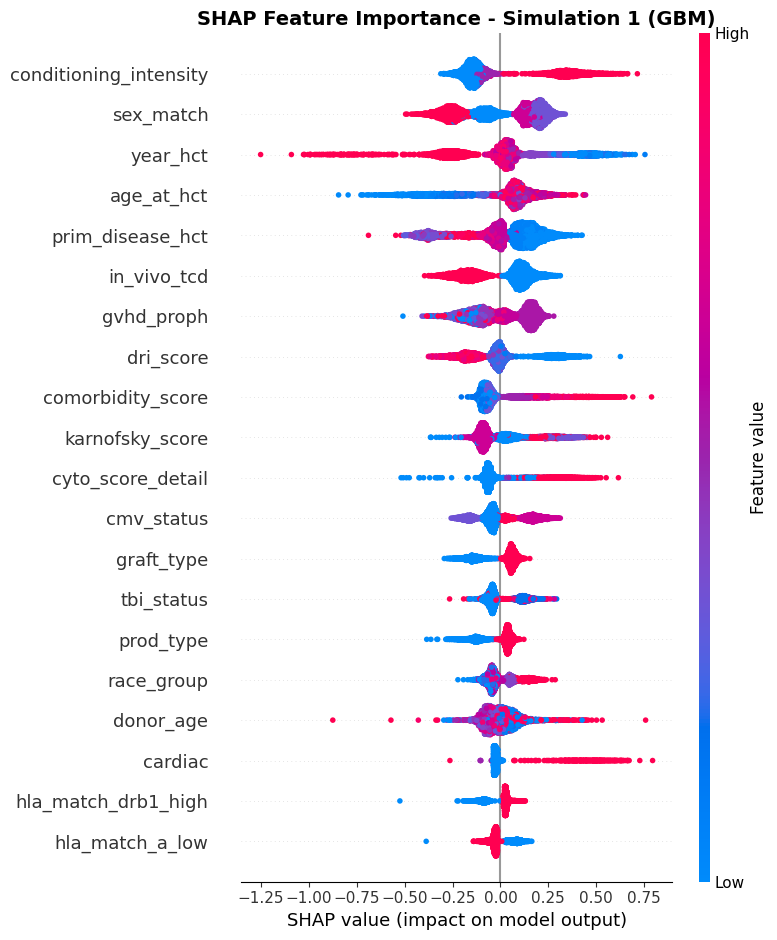


Plot saved: shap_simulation1.png


In [16]:
# ------------------------------
# CELL 12: SHAP Analysis
# ------------------------------
# Explain which features drive predictions
# ------------------------------
!pip install shap -q

import shap
import warnings
warnings.filterwarnings('ignore')

# Use best model
best_idx = np.argmax(results['auc'])
best_model = results['models'][best_idx]

# Get test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(">>> SHAP Analysis")
print(f"    Using best model (AUC: {results['auc'][best_idx]:.4f})")

# Calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=all_features, show=False)
plt.title('SHAP Feature Importance - Simulation 1 (GBM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_simulation1.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: shap_simulation1.png")